In [2]:

import pandas as pd
from experiments.musique.inference_only import macro_averaging
from knowledge_propagation.utils import io, vars, extractor
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import describe
from thefuzz import fuzz


from knowledge_propagation.modules.evaluators import (
    ExactMatchEvaluator,
    RougeEvaluator,
    OpenAIEvaluator,
)
llm_evaluator = OpenAIEvaluator()

os.getcwd()

'/datastor1/zliu/mend/notebooks'

In [27]:
task = "musique"
edit_loss="clm"
edit_input="question"
prompt = "urial"
exp_name = "llama3.2-1B_on_musique" # llama3.2-1B_on_musiqueQonly
fpath = f"../exp_output/{exp_name}/{task}/mend_eval_loss={edit_loss}_input={edit_input}_n=1000_prompt={prompt}.xlsx"
# print("File name:", fpath)
# fpath = "/u/zliu/datastor1/mend/exp_output/musique_injector/musique/mend_eval_loss=clm_input=question_n=1000_prompt=no_w-gen_wo-icl_textidx1_split.xlsx"
fpath = "/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=seen-hop_lr=1e-05_epoch=4.0/all_table_new_e+s.xlsx"
do_gen = "w-gen" in fpath
df = pd.read_excel(fpath)
metrics = ["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"]
if do_gen:
    metrics += ["rouge1", "llm_accuracy"]
# macro_averaging(df, multi_levelz_averaging=["stage", "question"], metrics=['[Q][A] acc', "rouge1", "llm_accuracy"])
len(df)


9000

In [60]:
# df[df["stage"] == "pre-edit"]

In [153]:
# macro_averaging(df, multi_level_averaging=["stage", "input"], metrics=metrics) * 100
macro_averaging(df[df["stage"] == "pre-edit"], multi_level_averaging=["question_tag", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"] + ["rouge1", "llm_accuracy"]) * 100

,question_tag,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,rouge1,llm_accuracy
0,multi_hop_efficacy_q0multi_hop_efficacy_q0mult...,2.2,49.709308,0.0,31.329471,7.311056,17.68
1,single_hop_efficacy_q0single_hop_efficacy_q0si...,5.9,56.474287,0.0,32.867520,11.050714,20.63
2,single_hop_efficacy_q1single_hop_efficacy_q1si...,6.1,55.455765,0.0,35.371379,12.870054,22.96


In [190]:
len(df[df["stage"] == "pre-edit"])

0

In [21]:
len(df[df["stage"] == "post-edit"])

9000

In [17]:
# df[(df["stage"] == "post-edit") & (df["question_type"] == "single_hop_efficacy")].sample(10)

In [28]:
(macro_averaging(df[df["stage"] == "post-edit"], multi_level_averaging=["question_tag", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", ] + ["rouge1", "llm_accuracy"]) * 100).round(1) # llm_accuracy '[Q][A] Acc EM', "[Q][A] Acc PM" question_tag

,question_tag,[A]|[Q] Acc EM,[A]|[Q] Acc PM,rouge1,llm_accuracy
0,multi_hop_efficacyq0multi_hop_efficacyq0multi_...,3.3,53.5,15.8,28.5
1,multi_hop_specificityq0multi_hop_specificityq0...,35.9,73.7,46.5,57.0
2,multi_hop_specificityq1multi_hop_specificityq1...,41.9,76.7,52.1,62.4
3,single_hop_efficacyq0single_hop_efficacyq0sing...,13.7,62.3,30.7,46.3
4,single_hop_efficacyq1single_hop_efficacyq1sing...,8.7,60.6,22.8,35.9
5,single_hop_specificityq0single_hop_specificity...,80.7,92.9,88.3,91.8
6,single_hop_specificityq1single_hop_specificity...,59.2,85.1,73.4,79.9
7,single_hop_specificityq2single_hop_specificity...,81.3,93.3,89.8,93.4
8,single_hop_specificityq3single_hop_specificity...,59.8,85.2,74.4,82.6


In [23]:
(macro_averaging(df[df["stage"] == "post-edit"], multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", ] + ["rouge1", "llm_accuracy"]) * 100).round(1) # llm_accuracy '[Q][A] Acc EM', "[Q][A] Acc PM" question_tag

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,rouge1,llm_accuracy
0,multi_hop_efficacymulti_hop_efficacymulti_hop_...,7.7,64.3,16.4,24.8
1,multi_hop_specificitymulti_hop_specificitymult...,38.1,75.6,48.5,58.9
2,single_hop_efficacysingle_hop_efficacysingle_h...,23.8,73.0,33.9,40.7
3,single_hop_specificitysingle_hop_specificitysi...,69.9,89.6,80.4,85.5


In [25]:
(macro_averaging(df[df["stage"] == "pre-edit"], multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", ] + ["rouge1", "llm_accuracy"]) * 100).round(1) # llm_accuracy '[Q][A] Acc EM', "[Q][A] Acc PM"

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,rouge1,llm_accuracy
0,multi_hop_specificitymulti_hop_specificitymult...,40.6,76.4,50.4,61.4
1,single_hop_specificitysingle_hop_specificitysi...,73.3,90.6,82.3,87.5


In [20]:
df["stage"] == "pre-edit"

0       True
1       True
2       True
3       True
4       True
        ... 
5995    True
5996    True
5997    True
5998    True
5999    True
Name: stage, Length: 6000, dtype: bool

In [23]:
len(df[(df["stage"] == "pre-edit") & (df["question_type"] == "single_hop_specificity")])

4000

In [24]:
len(df[(df["stage"] == "pre-edit") & (df["question_type"] == "multi_hop_specificity")])

2000

In [184]:
for q_tag, q_df in df[df["stage"] == "pre-edit"].groupby("question_tag"):
    print(q_tag + ":", sum(isinstance(x, str) for x in q_df["predicted_answer"].to_list()))

multi_hop_efficacy_q0: 999
single_hop_efficacy_q0: 802
single_hop_efficacy_q1: 744


In [45]:
dev_ids = [ex["id"] for ex in io.load_jsonlines(f"{vars.DATA_DIR}/musique_mend/2hop_musique_ans_v1.0_dev.jsonl")[:1000]]

In [ ]:
pd.read_excel("/u/zliu/datastor1/KE-by-CP/exp_output/musique_single_dev_Llama-3.2-1B/rag=oracle_0icl_tag=paragraph/all_results.xlsx")
df = df[df["id"].isin(dev_ids)]
print(len(df))
macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["rouge1", "llm_accuracy"])

1000


,question_type,rouge1,llm_accuracy
0,multi_hop_efficacy,0.131099,0.3458


In [38]:
musique_wo_icl_df = pd.read_excel("/data/users/zliu/mend/exp_output/musique_propagator_p0/musique/mend_eval_loss=clm_input=2doc_n=1000_prompt=no_w-gen_w-icl.xlsx")
musique_wo_icl_df = musique_wo_icl_df[musique_wo_icl_df["stage"] == "post-edit"]
musique_wo_icl_df_content = musique_wo_icl_df.to_dict("records")

musique_w_icl_df = pd.read_excel("/data/users/zliu/mend/exp_output/musique_propagator_p0_w-newline_icl/musique/mend_eval_loss=clm_input=2doc_n=1000_prompt=no_w-gen_w-icl.xlsx")
musique_w_icl_df = musique_w_icl_df[musique_w_icl_df["stage"] == "post-edit"]
musique_w_icl_df_content = musique_w_icl_df.to_dict("records")
# df = df[df["id"].isin(dev_ids)]
# print(len(df))
# macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["rouge1", "llm_accuracy"])

In [46]:
io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/musique_mend_converted/2hop_musique_ans_v1.0_dev_w-spec.jsonl")[0]

{'id': '2hop__460946_294723',
 'texts': ['Green is the fourth studio album by British progressive rock musician Steve Hillage. Written in spring 1977 at the same time as his previous album, the funk-inflected "Motivation Radio" (1977), "Green" was originally going to be released as "The Green Album" as a companion to "The Red Album" (the originally intended name for "Motivation Radio"). However, this plan was dropped and after a US tour in late 1977, "Green" was recorded alone, primarily in Dorking, Surrey, and in London.',
  'Miquette Giraudy (born 9 February 1953, Nice, France) is a keyboard player and vocalist, best known for her work in Gong and with her partner Steve Hillage. She and Hillage currently form the core of the ambient band System 7. In addition to her performances in music, she has also worked as an actress, film editor and writer. In each role, she has used different stage names.'],
 'multi_hop_efficacy': [{'question': 'Who is the spouse of the Green performer?',
   '

In [40]:
merged_df_content = []
for wo_icl_row, w_icl_row in zip(musique_wo_icl_df_content, musique_w_icl_df_content):
    wo_icl_row["method"] = "MEND-propagator"
    w_icl_row["method"] = "MEND-propagator-icl"
    merged_df_content.append(wo_icl_row)
    merged_df_content.append(w_icl_row)

In [41]:
merged_df = pd.DataFrame(merged_df_content)
method_col = merged_df["method"]

merged_df.drop(labels=["method"], axis=1,inplace = True)
merged_df.insert(2, "method", method_col)

In [ ]:
merged_df.to_excel("/data/users/zliu/mend/spotcheck/compare-icl-or-woicl.xlsx", index=False)

In [40]:
macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["rouge1", "llm_accuracy"])

,question_type,rouge1,llm_accuracy
0,multi_hop_efficacy,0.060712,0.1399


In [ ]:
pd.read_excel()

In [15]:
df.insert(df.shape[-1], "haha", 9)

# analayze relation between edit success and norm

### in question-only

In [45]:
len(edit_model_infos)

1000

In [32]:
model_info_metrics = ["grad/true_mag", "grad/pseudo_mag", "grad/diff", "grad/cos"]
end_eval_metric = "[A]|[Q] Acc PM"
# end_eval_metric = "llm_accuracy"
correlation_df_content = []
edit_loss = "sft"
for tag, exp_dir in [(f"zsRE-14K::{edit_loss.upper()}", "llama3.2-1B_on_zsre-14K-debug"), (f"MuSiQue::{edit_loss.upper()}", "llama3.2-1B_on_musiqueQonly-debug")]:
    # 
    edit_model_infos = io.load_jsonlines(f"../exp_output/{exp_dir}/musique/mend_eval_loss={edit_loss}_input=question_n=1000_prompt=no_edit-model-infos.jsonl")

    df = pd.read_excel(f"../exp_output/{exp_dir}/musique/mend_eval_loss={edit_loss}_input=question_n=1000_prompt=no_w-gen.xlsx")
    
    post_edit_df = df[df["stage"] == "post-edit"]
    assert len(edit_model_infos) == len(post_edit_df)

    for i in range(len(edit_model_infos)):
        edit_model_info = edit_model_infos[i]
        assert edit_model_info["input"] == post_edit_df.iloc[i]["input"]
        for model_info_metric in model_info_metrics:
            correlation_df_content.append({
                "tag": tag,
                "model_info_metric": model_info_metric,
                "model_info_value": np.mean([v for k,v in edit_model_info.items() if k.startswith(model_info_metric)]),
                end_eval_metric: post_edit_df.iloc[i][end_eval_metric],
            })

In [33]:
correlation_df = pd.DataFrame(correlation_df_content)

In [34]:
color_dict = {
    f"zsRE-14K::{edit_loss.upper()}": sns.color_palette("tab10")[0],
    f"MuSiQue::{edit_loss.upper()}": sns.color_palette("tab10")[1]
    # Add more mappings as needed
}

In [39]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [36]:
correlation_df

,tag,model_info_metric,model_info_value,[A]|[Q] Acc PM
0,zsRE-14K::SFT,grad/true_mag,26.930911,0.857143
1,zsRE-14K::SFT,grad/pseudo_mag,32368.797960,0.857143
2,zsRE-14K::SFT,grad/diff,32355.658854,0.857143
3,zsRE-14K::SFT,grad/cos,0.499060,0.857143
4,zsRE-14K::SFT,grad/true_mag,25.779720,0.800000
...,...,...,...,...
7995,MuSiQue::SFT,grad/cos,0.220865,0.857143
7996,MuSiQue::SFT,grad/true_mag,24.308889,1.000000
7997,MuSiQue::SFT,grad/pseudo_mag,60042.998915,1.000000
7998,MuSiQue::SFT,grad/diff,60037.484158,1.000000


In [37]:
import seaborn.objects as so

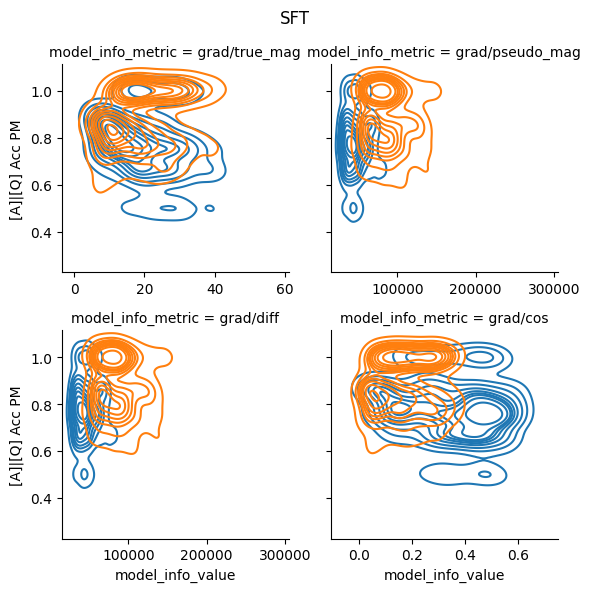

In [38]:
g = sns.FacetGrid(
    correlation_df,
    col="model_info_metric",
    col_wrap=2,
    hue="tag", palette=color_dict,
    sharex=False
)
g.map(sns.kdeplot, "model_info_value", end_eval_metric,)
plt.suptitle(edit_loss.upper())
plt.tight_layout()
plt.show()

In [109]:
len(io.load_json("/data/users/zliu/malmen/malmen_data/zsre/zsre_eval.json"))

19086

In [110]:
19086 / 37

515.8378378378378

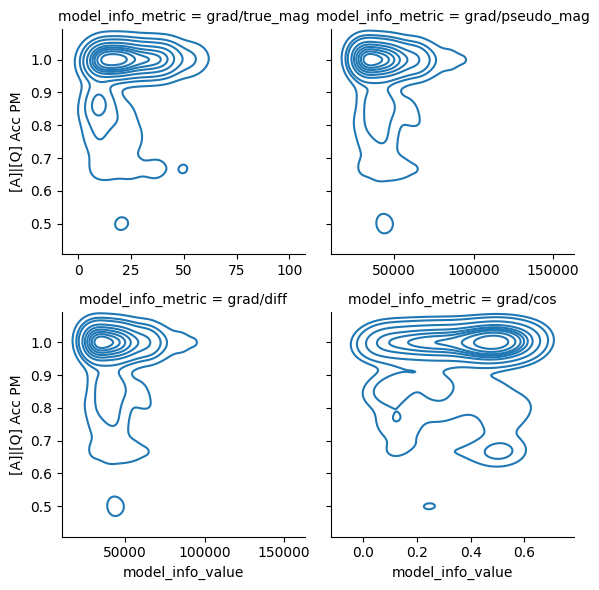

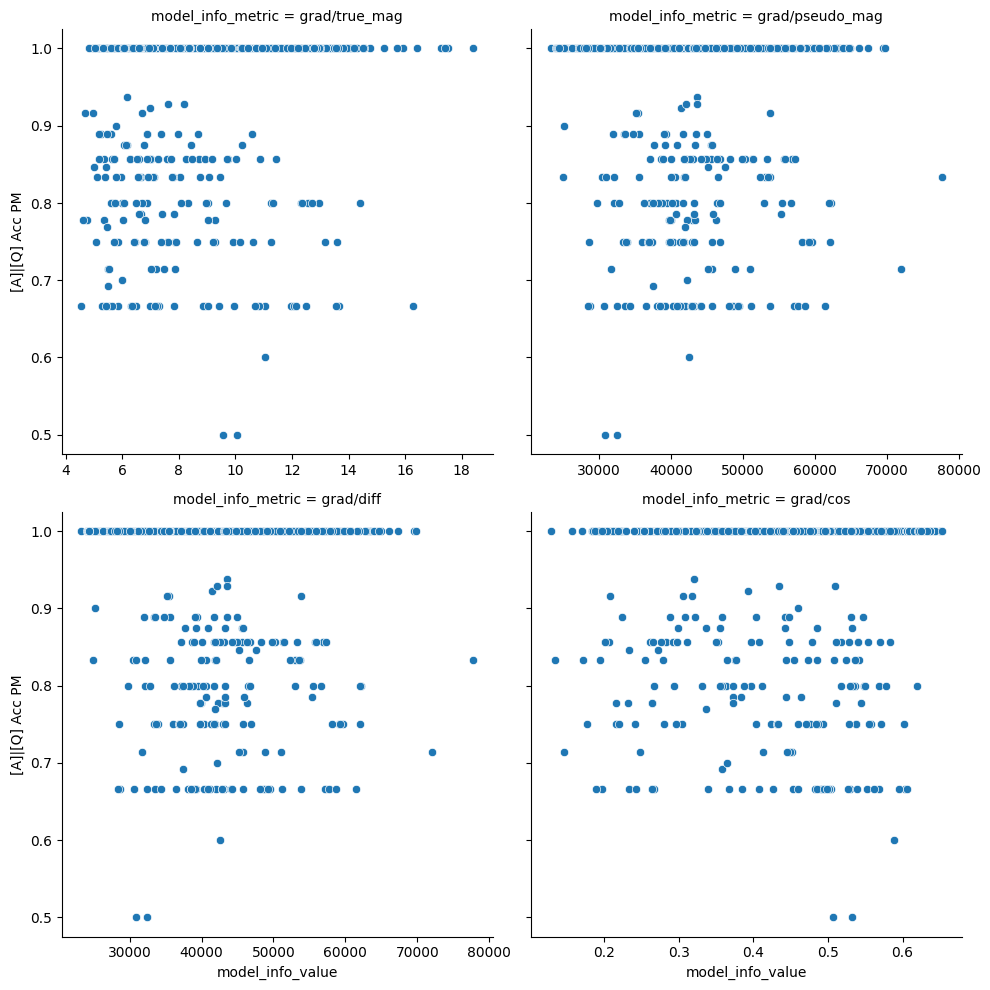

In [40]:
# sns.relplot(
#     data=correlation_df,
#     x="model_info_value", 
#     y=end_eval_metric, 
#     col="model_info_metric", 
#     col_wrap=2,
#     facet_kws={ 'sharex': False}
# )

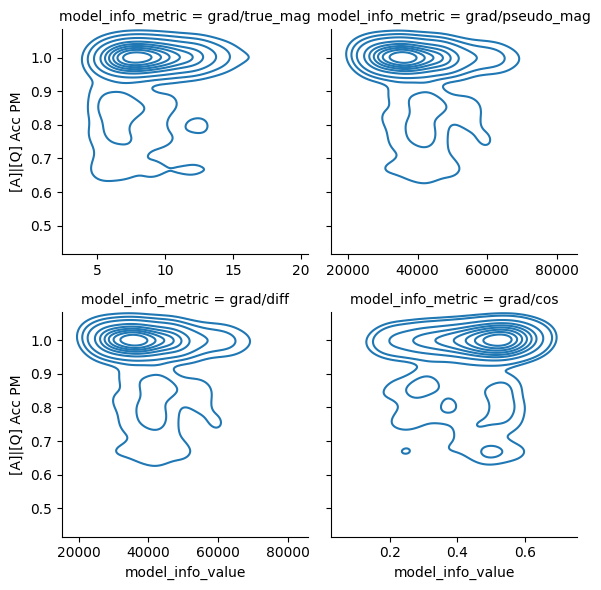

# Check which ones are missing 


In [7]:
save_dir = "/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_sft-baseline_input=2hop_lr=1e-05_epoch=4.0/individual_results_spec"
dev_example_ids = [x["id"] for x in io.load_jsonlines(f"{vars.DATA_DIR}/musique_mend_converted/2hop_musique_ans_v1.0_dev.jsonl")]
dev_example_ids = dev_example_ids[:1000]
missing_idx = []
for i, dev_example_id in enumerate(dev_example_ids):
    if not os.path.exists(f"{save_dir}/{dev_example_id}_eval_results.xlsx"):
        missing_idx.append(i)
print("Missing:", len(missing_idx))

Missing: 4


In [8]:
dev_example_ids[171]

'2hop__847433_11402'

In [9]:
" ".join(f"{x}" for x in missing_idx)

'169 170 171 172'

In [43]:
" ".join(str(x) for x in missing_idx)

''

In [5]:
len(missing_idx)

11

In [24]:
save_dir = "/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=seen-hop_lr=1e-05_epoch=4.0/individual_results"
all_df = pd.concat([pd.read_excel(f) for f in glob(f"{save_dir}/*.xlsx", recursive=True)])
len(all_df)

9000

In [25]:
dev_example_ids = [x["id"] for x in io.load_jsonlines(f"{vars.DATA_DIR}/musique_mend_converted/2hop_musique_ans_v1.0_dev.jsonl")[:1000]]
dev_example_ids = dev_example_ids

one_K_all_df = all_df[all_df["id"].isin(dev_example_ids)]
len(one_K_all_df)

9000

In [26]:
one_K_all_df.to_excel(f"{save_dir}/../all_table_new_e+s.xlsx", index=False)

In [41]:
macro_averaging(one_K_all_df, multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"] + ["rouge1", ]) * 100

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,rouge1
0,multi_hop_efficacymulti_hop_efficacymulti_hop_...,0.000,50.000001,0.0,42.991386,0.000000
1,multi_hop_specificitymulti_hop_specificitymult...,38.450,74.916248,0.0,44.273972,49.877938
2,single_hop_efficacysingle_hop_efficacysingle_h...,12.500,68.660715,0.0,45.244334,12.500000
3,single_hop_specificitysingle_hop_specificitysi...,70.175,89.084718,0.0,52.018154,81.325262


In [49]:
import math
one_K_all_df = pd.read_excel(f"{save_dir}/../all_table.xlsx")

describe([
    len(vars.GPT_4_TOKENIZER(ans))
    for ans in one_K_all_df["predicted_answer"].to_list() # [one_K_all_df["question_type"] == "single_hop_efficacy"]
    if isinstance(ans, str)
])

DescribeResult(nobs=2920, minmax=(np.int64(1), np.int64(22)), mean=np.float64(16.71027397260274), variance=np.float64(33.4864308944234), skewness=np.float64(-1.423181597382786), kurtosis=np.float64(0.37896054426006387))

NameError: name 'q_df' is not defined

In [24]:
len(vars.GPT_4_TOKENIZER(one_K_all_df["predicted_answer"][0]))

2

In [38]:
math.isnan(one_K_all_df["predicted_answer"].to_list()[7])

True

# Split single-hop questions

In [18]:
id2single_hops = {x['id']: x["single_hop_efficacy"] for x in io.load_jsonlines(f"{vars.DATA_DIR}/musique_mend_converted/2hop_musique_ans_v1.0_dev.jsonl")[:1000]}

In [19]:
id2single_hops["2hop__108336_772156"]

[{'id': 108336,
  'question': "Which was the creator of allegory of isabella d'este's coronation?",
  'answer': 'Lorenzo Costa',
  'supporting_text_id': 0},
 {'id': 772156,
  'question': 'Where did lorenzo costa pass away according to his place of death?',
  'answer': 'Mantua',
  'supporting_text_id': 1}]

In [4]:
# {x['id']: x["multi_hop_efficacy"] for x in io.load_jsonlines(f"{vars.DATA_DIR}/musique_mend_converted/2hop_musique_ans_v1.0_dev.jsonl")[:1000]}

In [20]:
df_path = "/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=seen-hop_lr=1e-05_epoch=4.0/all_table_e+s.xlsx"

df = pd.read_excel(df_path)

df_multiplier = 2 if "pre-edit" in df["stage"].tolist() and "post-edit" in df["stage"].tolist() else 1

In [24]:
instance_df

,id,question_type,clm_input,stage,question,answer,predicted_answer_idx,predicted_answer,exact_match,rouge1,rouge2,rougeL,rougeLsum,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,llm_accuracy
2792,2hop__10017_18974,single_hop_specificity,[[In 677 (during the reign of Emperor Gaozong)...,post-edit,Which ocean lies to the east of Australia?,Pacific Ocean,0,Indian Ocean,0,0.500000,0.0,0.500000,0.500000,0,0.666667,0,0.416667,0.1
2793,2hop__10017_18974,single_hop_specificity,[[In 677 (during the reign of Emperor Gaozong)...,post-edit,Who was the first person to land on the moon?,Neil Armstrong,0,Neil Armstrong,1,1.000000,1.0,1.000000,1.000000,1,1.000000,0,0.714286,1.0
2794,2hop__10017_18974,single_hop_specificity,[[In 677 (during the reign of Emperor Gaozong)...,post-edit,Which country is known as the Land of the Risi...,Japan,0,Japan,1,1.000000,0.0,1.000000,1.000000,1,1.000000,0,0.428571,1.0
2795,2hop__10017_18974,single_hop_specificity,[[In 677 (during the reign of Emperor Gaozong)...,post-edit,Who developed the theory of relativity?,Albert Einstein,0,Albert Einstein,1,1.000000,1.0,1.000000,1.000000,1,1.000000,0,0.636364,1.0
2796,2hop__10017_18974,multi_hop_specificity,[[In 677 (during the reign of Emperor Gaozong)...,post-edit,Which ocean lies to the east of the continent ...,Atlantic Ocean,0,Pacific Ocean,0,0.500000,0.0,0.500000,0.500000,0,0.666667,0,0.388889,0.1
2797,2hop__10017_18974,multi_hop_specificity,[[In 677 (during the reign of Emperor Gaozong)...,post-edit,"Which country, known as the Land of the Rising...",Japan,0,Japan,1,1.000000,0.0,1.000000,1.000000,1,1.000000,0,0.392857,1.0
2798,2hop__10017_18974,single_hop_efficacy,[[In 677 (during the reign of Emperor Gaozong)...,post-edit,Who led the military expedition in Fujian ?,Chen Zheng,0,"Zhang Zheng (陳政), together with his son Zhang ...",0,0.181818,0.0,0.181818,0.181818,0,0.333333,0,0.333333,0.3
2799,2hop__10017_18974,multi_hop_efficacy,[[In 677 (during the reign of Emperor Gaozong)...,post-edit,Who led the military expedition in the provinc...,Chen Zheng,0,"Zhang Zheng (陳政), together with his son Zhang ...",0,0.181818,0.0,0.181818,0.181818,0,0.333333,0,0.200000,0.3


In [22]:
new_df = []
for ins_id, instance_df in df.groupby("id"):
    # assert len(instance_df) == 3 * df_multiplier, ins_id
    single_hop_df = instance_df[instance_df["question_type"] == "single_hop_efficacy"]
    assert len(single_hop_df) == 2 * df_multiplier
    
    for r_i, row in single_hop_df.iterrows():
        
        row_dict = row.to_dict()
        try:
            question_lst = [q["question"] for q in id2single_hops[ins_id]]
            q_index: int = int(np.argmax([fuzz.ratio(q, row_dict["question"]) for q in question_lst]))
        except:
            print(ins_id)
            assert False
        row_dict["question_tag"] = f"single_hop_efficacy_q{q_index}"
        new_df.append(row_dict)

    multi_hop_df = instance_df[instance_df["question_type"] == "multi_hop_efficacy"]
    assert len(multi_hop_df) == 1 * df_multiplier
    
    for r_i, row in multi_hop_df.iterrows():
        
        row_dict = row.to_dict()
        row_dict["question_tag"] = f"multi_hop_efficacy_q0"
        new_df.append(row_dict)


AssertionError: 

In [11]:
pd.DataFrame(new_df).to_excel(io.remove_last_extension(df_path) + "_split.xlsx", index=False)

ModuleNotFoundError: No module named 'thefuzz'

In [108]:
for r_i, row in single_hop_df.iterrows():
    q_index: int = [q["question"] for q in id2single_hops[ins_id]].index(row["question"])
    row["question_tag"] = f"single_hop_efficacy_q{q_index}"
    pass

In [109]:
row

Unnamed: 0                                                              1
id                                                        2hop__998_25855
question_type                                         single_hop_efficacy
clm_input               [[The third generation began including a 30-pi...
stage                                                           post-edit
question                What does dell call the feature that lets USB ...
answer                                                         PowerShare
predicted_answer_idx                                                    0
predicted_answer                                                    Sleep
exact_match                                                             0
rouge1                                                                0.0
rouge2                                                                0.0
rougeL                                                                0.0
rougeLsum                             

1

'What does dell call the feature that lets USB drives to remain powered when the computer is off?'

In [22]:
df1 = pd.read_excel("/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=first-1hop_lr=1e-05_epoch=4.0/all_table.xlsx")
df2 = pd.read_excel("/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=second-1hop_lr=1e-05_epoch=4.0/all_table.xlsx")
df = pd.concat([df1, df2])

In [23]:
df[df["stage"] == "post-edit"].head()

,Unnamed: 0,id,question_type,clm_input,stage,question,answer,predicted_answer_idx,predicted_answer,exact_match,rouge1,rouge2,rougeL,rougeLsum,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,llm_accuracy
0,0,2hop__159903_154896,single_hop_efficacy,[[He was elected to the NLF executive in the f...,post-edit,What part of the country is it about?,South Yemen,0,Northern Ireland,0,0.0,0.0,0.0,0.0,0,0.666667,0,0.416667,NaN
1,1,2hop__159903_154896,single_hop_efficacy,[[He was elected to the NLF executive in the f...,post-edit,What year did South Yemen insurgency start?,27 April 2009,0,1965,0,0.0,0.0,0.0,0.0,0,0.571429,0,0.333333,NaN
2,2,2hop__159903_154896,multi_hop_efficacy,[[He was elected to the NLF executive in the f...,post-edit,In what year did the insurgency start in the p...,27 April 2009,0,1965,0,0.0,0.0,0.0,0.0,0,0.428571,0,0.375000,NaN
3,0,2hop__341305_332933,single_hop_efficacy,[[Pine Springs is an unincorporated community ...,post-edit,In which administrative territorial entity is ...,Culberson County,0,"The state of Texas, United States. Pine Spring...",0,0.0,0.0,0.0,0.0,0,0.600000,0,0.200000,0.7
4,1,2hop__341305_332933,single_hop_efficacy,[[Pine Springs is an unincorporated community ...,post-edit,What is the capital of culberson county?,Van Horn,0,"Fort Worth, Texas, United States. It is the cl...",0,0.0,0.0,0.0,0.0,0,0.333333,0,0.538462,0.1


In [24]:
len(df[df["stage"] == "post-edit"])

6000

In [25]:
macro_averaging(df[df["stage"] == "post-edit"], multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"] + ["rouge1", "llm_accuracy"]) * 100

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,rouge1,llm_accuracy
0,multi_hop_efficacymulti_hop_efficacymulti_hop_...,3.550,52.908916,0.0,37.829996,15.716392,35.1750
1,single_hop_efficacysingle_hop_efficacysingle_h...,8.425,59.864995,0.0,41.268511,23.778972,38.8625


In [27]:
raw_questions = []
for icl_question in df["question"]:
    question_ = icl_question.split("\n")[-2].strip()
    assert "Q: " in question_
    raw_questions.append(question_[3:])
    

6000

In [28]:
raw_questions[:3]

['Who is the performer associated with green?',
 'Who is the spouse of steve hillage?',
 'Who is the spouse of the Green performer?']

In [29]:
scored_df = llm_acc_per_example = llm_evaluator.compute_metric(
    questions=raw_questions,
    predictions=df["predicted_answer"],
    references=df["answer"],
    use_aggregator=False,
    rescale_to_one=True,
)

2025-02-26 21:51:25.107 | INFO     | knowledge_propagation.modules.evaluators:compute_metric:104 - Evaluating with LLM evaluator (gpt-4o-mini)


Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix
Failing heuristic fix


In [37]:
df["llm_accuracy"] = scored_df["llm_accuracy"]

In [41]:
macro_averaging(df[df["stage"] == "pre-edit"], multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"] + ["rouge1", "llm_accuracy"]) * 100

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,rouge1,llm_accuracy
0,multi_hop_efficacymulti_hop_efficacymulti_hop_...,1.5,48.632919,0.0,37.569110,5.807457,16.170
1,single_hop_efficacysingle_hop_efficacysingle_h...,6.2,54.202771,0.0,38.640035,12.080476,23.095


In [40]:
macro_averaging(df[df["stage"] == "post-edit"], multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"] + ["rouge1", "llm_accuracy"]) * 100

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,rouge1,llm_accuracy
0,multi_hop_efficacymulti_hop_efficacymulti_hop_...,7.85,58.005100,0.0,40.070285,15.668783,24.8950
1,single_hop_efficacysingle_hop_efficacysingle_h...,19.40,67.272676,0.0,41.425836,28.166019,35.8125


In [49]:
for x in io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/musique_mend_converted/2hop_musique_ans_v1.0_train.jsonl"):
    assert len(x["multi_hop_efficacy"]) == 1, x
    assert len(x["single_hop_efficacy"]) == 2, x

In [3]:
malmen_combiner_text_df = pd.read_excel("/u/zliu/datastor1/malmen/exp_output/musique_combiner_text_w-atomq_m1/malmen_eval_musique_combiner_text_n=1000.xlsx")
malmen_combiner_text_df = malmen_combiner_text_df[(malmen_combiner_text_df["stage"] == "post-edit") & (malmen_combiner_text_df["question_type"] == "multi_hop_efficacy")]

clm_combiner_text_df = pd.read_excel("/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/all_table_split.xlsx")
clm_combiner_text_df = clm_combiner_text_df[(clm_combiner_text_df["stage"] == "post-edit") & (clm_combiner_text_df["question_type"] == "multi_hop_efficacy")]

In [4]:
assert len(malmen_combiner_text_df) == len(clm_combiner_text_df)

In [5]:
c = 0
clm_better_rs = []
for r_i, clm_r in clm_combiner_text_df.iterrows():
    malmen_q_r = malmen_combiner_text_df[malmen_combiner_text_df["question"] == clm_r["question"]]
    if len(malmen_q_r) != 1:
        continue
    malmen_r = malmen_q_r.iloc[0]
    if clm_r["llm_accuracy"] > malmen_r["llm_accuracy"]:
        clm_better_rs.append((clm_r, malmen_r))
    

In [47]:
len(clm_better_rs)

287

In [31]:
with open("/u/zliu/datastor1/mend/spotcheck/clm_compq_better.txt", "w") as f:

    for clm_r, malmen_r in clm_better_rs[:]:
        f.write("=" * 60 + "\n")
        f.write("Example id: " + clm_r["id"] + "\n")
        f.write("Text:\n")
        f.write("-" * 40 + "\n")
        f.write(clm_r["clm_input"] + "\n")
        f.write("-" * 40 + "\n")
        f.write("CompQ: " + clm_r["question"] + "\n")
        f.write("Answer: " + clm_r["answer"] + "\n")
        f.write(f"CLM Prediction [llm_acc={clm_r['llm_accuracy']}]: " + clm_r["predicted_answer"] + "\n")
        f.write(f"MALMEN Prediction [llm_acc={malmen_r['llm_accuracy']}]: " + malmen_r["predicted_answer"] + "\n")
        f.write("=" * 60 + "\n\n")


In [ ]:

baseline = "/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_sh+mh/all_table_split.xlsx"

1.0

In [35]:
baseline = pd.read_excel("/u/zliu/datastor1/mend/exp_output/Llama-3.2-1B-eos-sft_sh+mh/all_table_split.xlsx")

In [45]:
with open("/u/zliu/datastor1/mend/spotcheck/eos-sft_EMvsRouge.txt", "w") as f:
    f.write("baseline_r[[A]|[Q] Acc EM] == 0 and baseline_r[rouge1]\n")
    interesting_rows = []
    for r_i, baseline_r in baseline.iterrows():
        if baseline_r["[A]|[Q] Acc EM"] == 0 and baseline_r["rouge1"] > 0:
            interesting_rows.append(baseline_r.to_dict())
            f.write("Answer: " + baseline_r["answer"] + "\n")
            f.write("Predicted Answer: " + baseline_r["predicted_answer"] + "\n")
            f.write("\n")
    # if 
    # malmen_q_r = malmen_combiner_text_df[malmen_combiner_text_df["question"] == clm_r["question"]]

{'Unnamed: 0': 2,
 'id': '2hop__998_25855',
 'question_type': 'multi_hop_efficacy',
 'question': 'What does dell call the feature letting the interface replacing FireWire in later iterations of the iPod drives to remain powered when the computer is off?',
 'stage': 'pre-edit',
 'answer': 'PowerShare',
 'predicted_answer_idx': 0,
 'predicted_answer': 'Sleep',
 'exact_match': 0,
 'rouge1': 0.0,
 'rouge2': 0.0,
 'rougeL': 0.0,
 'rougeLsum': 0.0,
 '[A]|[Q] Acc EM': 0,
 '[A]|[Q] Acc PM': 0.3333333432674408,
 '[Q][A] Acc EM': 0,
 '[Q][A] Acc PM': 0.161290317773819,
 'llm_accuracy': 0.1,
 'question_tag': 'multi_hop_efficacy_q0'}